In [11]:
import anndata
import networkx as nx
import scanpy as sc
from anndata import AnnData
import torch
from typing import Any, List, Mapping, Optional
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.config import configure_dataset
from src.train import covel_train
import dill
from src.auxtools import get_metacells

In [ ]:
dataset = "muto2021"
result_path = f"dataset/{dataset}/result"

rna = anndata.read_h5ad(f"./dataset/{dataset}/rna_hvg.h5ad")
atac = anndata.read_h5ad(f"./dataset/{dataset}/atac_hvg.h5ad")
graph = nx.read_graphml(f"./dataset/{dataset}/guidance-hvf.graphml.gz")

rna.obs['cell type'] = rna.obs['cell_type']
atac.obs['cell type'] = atac.obs['cell_type']

rna.obsm['X_pre'] = rna.X
atac.obsm['X_pre'] = atac.X

print(rna)
print(atac)
# rna.X=rna.layers['counts']
print(graph)

rna.X=rna.layers['counts']
atac.X=atac.layers['counts']

adatas=[rna, atac]
modal_names=["RNA", "ATAC"]
prob=['NB','NB']
rep = ['X_pre', 'X_pre']
cell_type = ['cell_type', 'cell_type']
# save_path = "./ckpt"

vertices = sorted(graph.nodes)
for idx, adata in enumerate(adatas):
    configure_dataset(adata, prob[idx], 
                      use_highly_variable=True,
                      use_rep=rep[idx],
                      use_cell_type=cell_type[idx])

data = dict(zip(modal_names, adatas))

with open(f'{result_path}/fine-tune stage 2/fine-tune.dill', 'rb') as f:
    covel = dill.load(f)

print("Integration data")
for modal_name in modal_names:
    data[modal_name].obsm['embedding'] = covel.encode_data(modal_name, data[modal_name])
    
combined = anndata.AnnData(
        obs=pd.concat([adata.obs for adata in adatas], join="inner"),
        obsm={"embedding": np.concatenate([
            adata.obsm["embedding"] for adata in adatas
        ])}
)

combined.obs["domain"] = pd.Categorical(
        combined.obs["domain"],
        # categories=modal_names
)

# combined.uns["domain_colors"] = list(sns.color_palette(n_colors=len(modal_names)).as_hex())

feature_embeddings = covel.encode_graph(graph)
feature_embeddings = pd.DataFrame(feature_embeddings, index=covel.vertices)

for adata in adatas:
    adata.varm["embedding"] = feature_embeddings.reindex(adata.var_names).to_numpy()

print("UMAP vis integration data, in combined.h5ad X_umap")
sc.pp.neighbors(combined, 
                # n_pcs=10, 
                use_rep=, metric="cosine""embedding")
sc.tl.umap(combined)

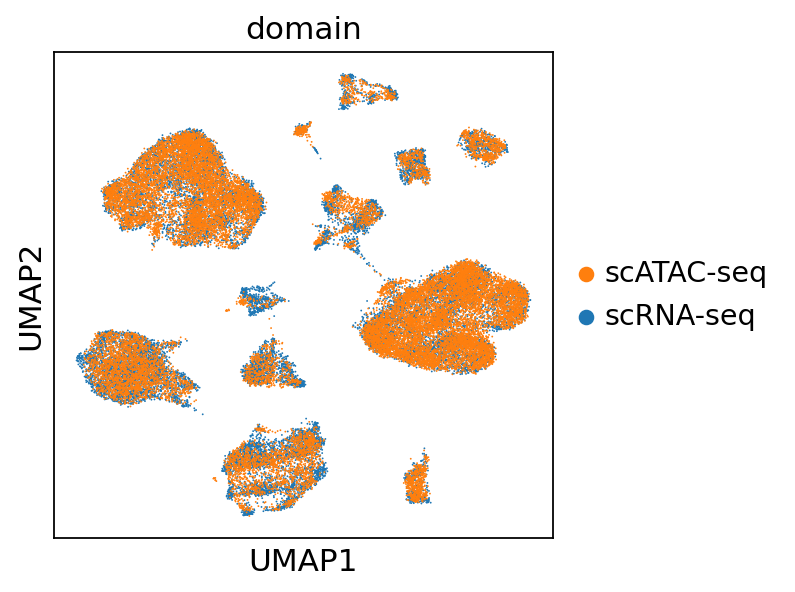

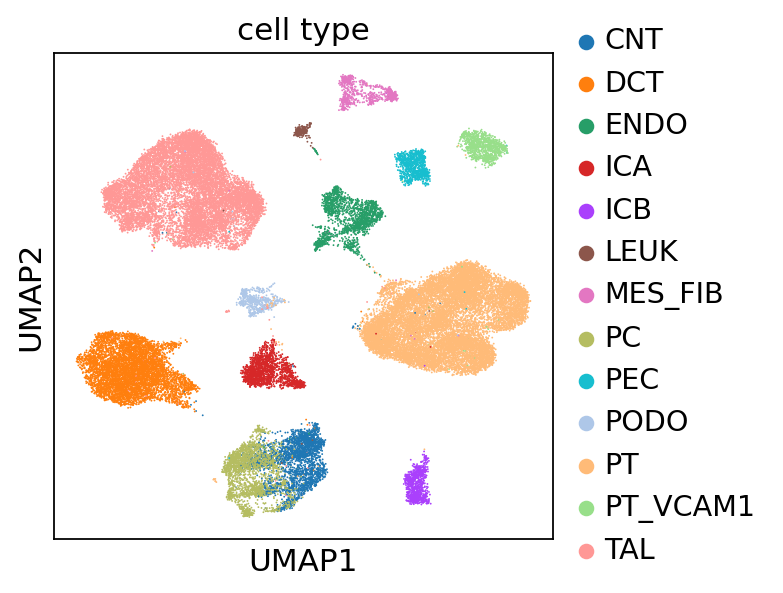

In [14]:
sc.set_figure_params(dpi=80)

combined.uns["domain_colors"] = list(sns.color_palette(n_colors=len(modal_names)).as_hex())[::-1]

sc.pl.umap(combined, color=['domain'])
sc.pl.umap(combined, color=['cell type'])